In [98]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold

In [57]:
data = pd.read_csv("bank-full.csv", sep=";")
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# Split 60% Train, 20% Test and 20% Validation

In [58]:
y = data['y']

In [59]:
train_data, temp_data = train_test_split(data, test_size=0.4, random_state=1)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=1)

In [60]:
# Optional: check the size of each split
print(f"Train data: {len(train_data)} rows")
print(f"Validation data: {len(val_data)} rows")
print(f"Test data: {len(test_data)} rows")

Train data: 27126 rows
Validation data: 9042 rows
Test data: 9043 rows


# Question 1: ROC AUC feature importance

In [61]:
numerical_columns = ['age', "day", "balance", "duration", "campaign", "pdays", "previous"]

In [62]:
auc_scores = {}

for col in numerical_columns:
    try:
        auc = roc_auc_score(train_data['y'], train_data[col])
        
        if auc <0.5:
            auc = roc_auc_score(train_data['y'], -train_data[col])
        
        auc_scores[col] = auc
        print(f"Feature: {col}, AUC: {auc}")
    except Exception as e:
        print(e)

best_feature = max(auc_scores, key=auc_scores.get)
print(f"Feature with highest AUC: {best_feature}, AUC: {auc_scores[best_feature]}")

Feature: age, AUC: 0.5125105881599707
Feature: day, AUC: 0.5291275984648961
Feature: balance, AUC: 0.5916931412945473
Feature: duration, AUC: 0.8128648066681694
Feature: campaign, AUC: 0.5742447701740003
Feature: pdays, AUC: 0.5897967289320412
Feature: previous, AUC: 0.5986704105715122
Feature with highest AUC: duration, AUC: 0.8128648066681694


# Question 2: Training the model

In [63]:
X_train = train_data.drop(columns= ["y"])
X_test = test_data.drop(columns= ["y"])
y_train = train_data['y']
y_test = test_data['y']

X_dict = X_train.to_dict(orient='records')
X_dict_test = X_test.to_dict(orient='records')

vectorizer = DictVectorizer(sparse=False)
X_encoded_train = vectorizer.fit_transform(X_dict)
X_encoded_test = vectorizer.fit_transform(X_dict_test)

In [64]:
log_reg = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
log_reg.fit(X_encoded_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [65]:
y_pred_proba = log_reg.predict_proba(X_encoded_test)[:, 1]  # Get the predicted probabilities for the positive class (class 1)

# Step 5: Calculate AUC on the test (validation) set
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.3f}")

AUC: 0.906


# Question 3: Precision and Recall

In [69]:
lb = LabelBinarizer()
# y_train_bin = lb.fit_transform(y_train).ravel()  # Convert y_train to binary
y_test_bin = lb.fit_transform(y_test).ravel()  # Convert y_test to binary

In [88]:
y_pred_proba = log_reg.predict_proba(X_encoded_test)[:, 1]  # Get the probabilities for the positive class
precisions, recalls, thresholds = precision_recall_curve(y_test_bin, y_pred_proba)
thresholds = np.append(thresholds, 1.0)

In [89]:
len(thresholds)

9044

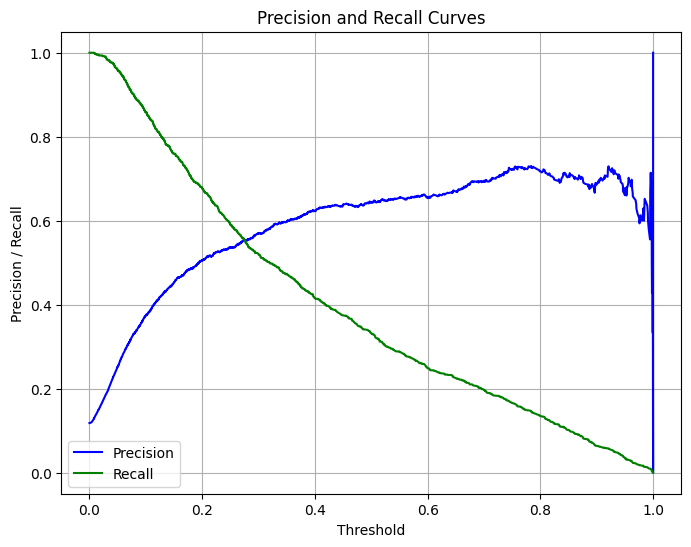

Precision and Recall intersect at threshold: 0.27


In [90]:


# Plot precision and recall curves
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label="Precision", color='b')
plt.plot(thresholds, recalls, label="Recall", color='g')

plt.xlabel("Threshold")
plt.ylabel("Precision / Recall")
plt.title("Precision and Recall Curves")
plt.legend()
plt.grid(True)
plt.show()

for p, r, t in zip(precisions, recalls, thresholds):
    if np.isclose(p, r, atol=0.01):  # Use a small tolerance for floating point comparison
        print(f"Precision and Recall intersect at threshold: {t:.2f}")
        break

# Question 4: F1 score

In [96]:
precisions, recalls, thresholds = precision_recall_curve(y_test_bin, y_pred_proba)

f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
f1_scores = np.nan_to_num(f1_scores)  # Handle any NaN values that may arise (if both precision and recall are 0)

max_f1_index = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_index]
max_f1_value = f1_scores[max_f1_index]

print(f"Max F1 Score: {max_f1_value:.3f} at Threshold: {max_f1_threshold:.2f}")

Max F1 Score: 0.581 at Threshold: 0.21


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9532\1662126415.py:3: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


# Question 5: 5-Fold CV

In [103]:

kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

X = train_data.drop('y', axis=1)  # Features
y = train_data['y']  # Target variable

for train_index, val_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_test = y.iloc[train_index], y.iloc[val_index]

    X_dict = X_train.to_dict(orient='records')
    X_dict_test = X_test.to_dict(orient='records')

    vectorizer = DictVectorizer(sparse=False)
    X_encoded_train = vectorizer.fit_transform(X_dict)
    X_encoded_test = vectorizer.fit_transform(X_dict_test)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_encoded_train, y_train)

    y_test_pred_proba = model.predict_proba(X_encoded_test)[:, 1] 
    auc = roc_auc_score(y_test, y_test_pred_proba)
    auc_scores.append(auc)

std_auc = np.std(auc_scores)

# Step 7: Display the AUC scores and standard deviation
print(f"AUC Scores for each fold: {auc_scores}")
print(f"Standard Deviation of AUC Scores: {std_auc:.3f}")

AUC Scores for each fold: [0.9105454569038621, 0.912673416275487, 0.9023746377181971, 0.9051918364606761, 0.9111355695112309]
Standard Deviation of AUC Scores: 0.004


# Question 6: Hyperparameter Tuning

In [104]:
# Assume df_full_train is your complete training DataFrame
# Prepare your data
X = train_data.drop('y', axis=1)  # Features
y = train_data['y']  # Target variable

# Apply One-Hot Encoding to categorical features
X_encoded = pd.get_dummies(X, drop_first=True)  # Convert categorical variables into dummy/indicator variables

# Define C values to evaluate
C_values = [0.000001, 0.001, 1]

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Dictionary to hold mean and std AUC scores for each C
results = {}

# Iterate over C values
for C in C_values:
    auc_scores = []  # List to store AUC scores for the current C value

    # Perform K-Fold cross-validation
    for train_index, val_index in kf.split(X_encoded):
        X_train, X_val = X_encoded.iloc[train_index], X_encoded.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Train the model
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        # Make predictions and calculate AUC
        y_val_pred_proba = model.predict_proba(X_val)[:, 1]  # Probability for the positive class
        auc = roc_auc_score(y_val, y_val_pred_proba)
        auc_scores.append(auc)

    # Compute mean and std of AUC scores
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)

    # Store the results
    results[C] = (mean_auc, std_auc)

# Display the results
for C, (mean_auc, std_auc) in results.items():
    print(f"C: {C:.6f} | Mean AUC: {mean_auc:.3f} | Std AUC: {std_auc:.3f}")

# Determine the best C
best_C = max(results, key=lambda x: results[x][0])
best_mean_auc = results[best_C][0]

print(f"\nBest C: {best_C} with Mean AUC: {best_mean_auc:.3f}")


C: 0.000001 | Mean AUC: 0.696 | Std AUC: 0.008
C: 0.001000 | Mean AUC: 0.855 | Std AUC: 0.005
C: 1.000000 | Mean AUC: 0.908 | Std AUC: 0.004

Best C: 1 with Mean AUC: 0.908
